Install packages (run only once in the runtime)

In [ ]:
!pip install deepxde

Imports and functions

In [ ]:
# This code is based off of the DeepXDE Lorenze Inverse example.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


In [ ]:
#Extract https://raw.githubusercontent.com/NolanKoblischke/GoodDynamics/main/ClimateData_.csv
import requests
import numpy as np
import pandas as pd

#Download the file to csv
url = 'https://raw.githubusercontent.com/NolanKoblischke/GoodDynamics/main/ClimateData_AverageTemperature.csv'
r = requests.get(url)
with open('ClimateData_AverageTemperature.csv', 'wb') as f:
    f.write(r.content)

#Read the file into a dataframe
df = pd.read_csv('ClimateData_AverageTemperature.csv', index_col=0)
#Only take Year, Temperature, Sea Ice Coverage, and CO2 (ppm)
df = df[['Year', 'Temperature', 'Sea Ice Coverage', 'CO2 (ppm)']]
df['Year'] = df['Year']-1959
#Make t numpy array with the years in shape (1,n)
ob_t = np.array(df['Year']).reshape(len(df['Year']),1)
#Make y numpy array from the rest of the columns
ob_y = np.array(df.drop('Year', axis=1))


In [ ]:
print(df.head())

   Year  Temperature  Sea Ice Coverage   CO2 (ppm)
0     0    14.013539          0.076864  316.280000
1     1    13.947003          0.075551  317.125833
2     2    14.037778          0.074863  317.988333
3     3    13.996948          0.075498  318.646667
4     4    14.023509          0.075833  319.417500


In [ ]:
# parameters to be identified
alpha1= tf.Variable(1.0)
alpha2= tf.Variable(1.0)
epsilon1= tf.Variable(1.0)
epsilon2= tf.Variable(1.0)
beta= tf.Variable(1.0)
a= tf.Variable(1.0)
b= tf.Variable(1.0)
k= tf.Variable(1.0)
m= tf.Variable(1.0)





$$
\begin{aligned}
&\frac{d T}{d t}=q(1-(\alpha_1 + \alpha_2 S))-(\epsilon_1+\epsilon_2 E)\sigma_{SB} T^{4}
\\
&\frac{d S}{d t}=\beta-a T \\
&\frac{d E}{d t}=b E+k
\end{aligned}
$$



In [ ]:
sigma = 1.947e-8 #Stefan Boltzmann
q = 117.445054945
# define system ODEs
def Climate_system(t, y):
    """Climate system. Columns T, S, E
    """
    T, S,E = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dT_t = dde.grad.jacobian(y, t, i=0)
    dS_t = dde.grad.jacobian(y, t, i=1)
    dE_t = dde.grad.jacobian(y, t, i=2)

    return [
      dT_t - q*(1-(alpha1+alpha2*S))+(epsilon1+epsilon2*E)*sigma*T**4,
      dS_t - beta+a*T,
      dE_t -b*E-k
    ]

def boundary(_, on_initial):
    return on_initial

In [ ]:
print("Initial Conditions: ", ob_y[0])
print("Date Range:", ob_t[0][0],ob_t[-1][0])

Initial Conditions:  [1.40135392e+01 7.68638220e-02 3.16280000e+02]
Date Range: 0 57


Define data and BCs

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  total_n_samples))


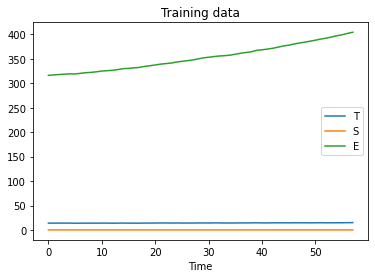

In [ ]:
# define time domain
geom = dde.geometry.TimeDomain(ob_t[0][0],ob_t[-1][0])

# Initial conditions
ic1 = dde.IC(geom, lambda X: ob_y[0][0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: ob_y[0][1], boundary, component=1)
ic3 = dde.IC(geom, lambda X: ob_y[0][2], boundary, component=2)



# Get the training data  Columns T, S, E
observe_T = dde.PointSetBC(ob_t, ob_y[:, 0:1], component=0)
observe_S = dde.PointSetBC(ob_t, ob_y[:, 1:2], component=1)
observe_E = dde.PointSetBC(ob_t, ob_y[:, 2:], component=2)


# define data object
data = dde.data.PDE(
    geom,
    Climate_system,
    [ic1, ic2, ic3, observe_T,  observe_S,  observe_E],
    num_domain=400,
    num_boundary=2,
    anchors=ob_t,
)

plt.plot(ob_t, ob_y)
plt.xlabel('Time')
plt.legend(['T','S','E'])
plt.title('Training data')
plt.show()


Train network

In [ ]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(    
    [alpha1, alpha2, epsilon1, epsilon2, beta, a, b, k], 
    period=1,
    filename=fnamevar
)



losshistory, train_state = model.train(epochs=150000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.078152 s



/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.185870 s

Initializing variables...
Training model...

0         [3.18e+01, 3.09e+00, 1.76e+00, 1.96e+02, 5.91e-03, 1.00e+05, 2.26e+02, 1.62e-03, 1.25e+05]    [3.18e+01, 3.09e+00, 1.76e+00, 1.96e+02, 5.91e-03, 1.00e+05, 2.26e+02, 1.62e-03, 1.25e+05]    []  
1000      [5.67e-06, 5.82e-03, 1.95e-02, 1.55e-02, 4.74e-03, 7.00e+04, 1.11e-01, 3.80e-03, 9.14e+04]    [5.67e-06, 5.82e-03, 1.95e-02, 1.55e-02, 4.74e-03, 7.00e+04, 1.11e-01, 3.80e-03, 9.14e+04]    []  
2000      [1.42e-06, 2.57e-11, 2.10e-06, 1.83e-02, 4.42e-03, 5.11e+04, 1.09e-01, 3.53e-03, 6.97e+04]    [1.42e-06, 2.57e-11, 2.10e-06, 1.83e-02, 4.42e-03, 5.11e+04, 1.09e-01, 3.53e-03, 6.97e+04]    []  
3000      [1.51e-04, 4.37e-12, 1.95e-07, 1.83e-02, 3.95e-03, 3.59e+04, 1.09e-01, 3.12e-03, 5.19e+04]    [1.51e-04, 4.37e-12, 1.95e-07, 1.83e-02, 3.95e-03, 3.59e+04, 1.09e-01, 3.12e-03, 5.19e+04]    []  
4000      [3.04e-06, 1.26e-12, 4.54e-08, 1.84e-02, 3.42e-03, 2.39e+04, 1.09e-01, 2.65e-03, 3.73e+04]    [3.04e-06, 1

KeyboardInterrupt: ignored

 Plot identified parameters

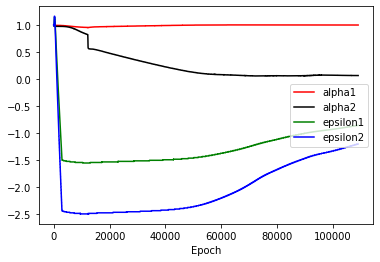

In [ ]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape
plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),Chat[:,3],'b-')



plt.legend(['alpha1', 'alpha2', 'epsilon1', 'epsilon2'],loc = "right")
plt.xlabel('Epoch')
plt.show()

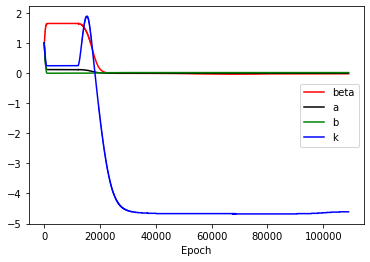

In [ ]:
plt.plot(range(l),Chat[:,4],'r-')
plt.plot(range(l),Chat[:,5],'k-')
plt.plot(range(l),Chat[:,6],'g-')
plt.plot(range(l),Chat[:,7],'b-')


plt.legend(['beta', 'a', 'b', 'k'],loc = "right")
plt.xlabel('Epoch')
plt.show()

In [ ]:
param_list = ['alpha1', 'alpha2', 'epsilon1', 'epsilon2', 'beta', 'a', 'b', 'k']

for i, val in enumerate(param_list):
  print(val, ":", Chat[-1,i])

alpha1 : 0.998
alpha2 : 0.0652
epsilon1 : -0.855
epsilon2 : -1.2
beta : -0.0218
a : -0.0015
b : 0.0174
k : -4.61


In [ ]:


future_t = np.arange(0,80,1)
ob_t = np.arange(0,58,1)
#change future_t shape to (1,n)
future_t = future_t.reshape(len(future_t),1)
'''n = 5000
end = 40000
for i in np.arange(0,end,n):
  k = Chat[i,-1]
  b = Chat[i,-2]
  E = np.exp(future_t*b-0.09)/b-k/b-1
  plt.plot((future_t+1956), E)
  plt.plot((ob_t+1956), df['CO2 (ppm)'])
  plt.title("CO2 Concentration (ppm) at epoch={}".format(i))
  plt.legend(['Predicted','Actual'],loc = "right")
  plt.xlabel("Year")
  plt.ylabel("CO2 Concentration (ppm)")
  plt.savefig("test2/plot{}.png".format(int(i/n)))
  plt.show()'''

'n = 5000\nend = 40000\nfor i in np.arange(0,end,n):\n  k = Chat[i,-1]\n  b = Chat[i,-2]\n  E = np.exp(future_t*b-0.09)/b-k/b-1\n  plt.plot((future_t+1956), E)\n  plt.plot((ob_t+1956), df[\'CO2 (ppm)\'])\n  plt.title("CO2 Concentration (ppm) at epoch={}".format(i))\n  plt.legend([\'Predicted\',\'Actual\'],loc = "right")\n  plt.xlabel("Year")\n  plt.ylabel("CO2 Concentration (ppm)")\n  plt.savefig("test2/plot{}.png".format(int(i/n)))\n  plt.show()'

In [ ]:
import os
filenames = sorted(os.listdir('test'))
print(filenames)
import imageio
images = []
for filename in filenames:
    filename = 'test/'+ filename
    print(filename)
    images.append(imageio.imread(filename))
imageio.mimsave('/movie.gif', images)

['plot0.png', 'plot1.png', 'plot10.png', 'plot11.png', 'plot12.png', 'plot13.png', 'plot14.png', 'plot15.png', 'plot16.png', 'plot17.png', 'plot18.png', 'plot19.png', 'plot2.png', 'plot20.png', 'plot21.png', 'plot22.png', 'plot23.png', 'plot24.png', 'plot25.png', 'plot26.png', 'plot27.png', 'plot28.png', 'plot29.png', 'plot3.png', 'plot30.png', 'plot31.png', 'plot32.png', 'plot33.png', 'plot34.png', 'plot35.png', 'plot36.png', 'plot37.png', 'plot38.png', 'plot39.png', 'plot4.png', 'plot5.png', 'plot6.png', 'plot7.png', 'plot8.png', 'plot9.png']
test/plot0.png
test/plot1.png
test/plot10.png
test/plot11.png
test/plot12.png
test/plot13.png
test/plot14.png
test/plot15.png
test/plot16.png
test/plot17.png
test/plot18.png
test/plot19.png
test/plot2.png
test/plot20.png
test/plot21.png
test/plot22.png
test/plot23.png
test/plot24.png
test/plot25.png
test/plot26.png
test/plot27.png
test/plot28.png
test/plot29.png
test/plot3.png
test/plot30.png
test/plot31.png
test/plot32.png
test/plot33.png
test/

In [ ]:

yhat = model.predict(ob_t)

plt.plot(ob_t, ob_y,'-',ob_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['T','S','E','Th','Sh','Eh'])
plt.title('Training data')
plt.show()

ValueError: ignored

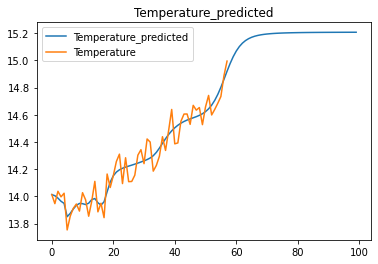

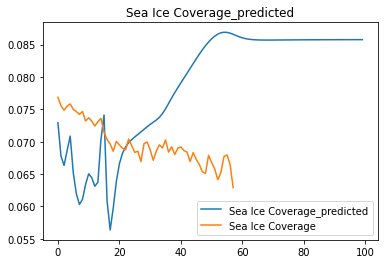

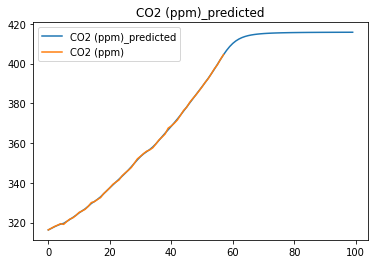

In [ ]:
df_yhat = pd.DataFrame(yhat, columns=df.columns[1:])
df_yhat.columns = [col+"_predicted" for col in df_yhat.columns]
for i in range(0,len(df_yhat.columns)):
  df_yhat.iloc[:,i].plot()
  df.iloc[:,i+1].plot()
  plt.legend(loc='best')
  plt.title(df_yhat.columns[i])
  plt.show()

In [ ]:
future_t = np.arange(0,100)
future_t = future_t.reshape(len(future_t),1)
yhat = model.predict(future_t)

plt.plot(ob_t, ob_y,'-',future_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['T','S','E','Th','Sh','Eh'])
plt.title('Training data')
plt.show()

In [ ]:

df_yhat = pd.DataFrame(yhat, columns=df.columns[1:])
df_yhat.columns = [col+"_predicted" for col in df_yhat.columns]
for i in range(0,len(df_yhat.columns)):
  df_yhat.iloc[:,i].plot()
  df.iloc[:,i+1].plot()
  plt.legend(loc='best')
  plt.title(df_yhat.columns[i])
  plt.show()
